## Cargar los datos 
### DataFrame:


In [2]:
# Importamos las librerías necesarias.
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Cargamos los datos.
valoraciones = pd.read_json('data/web_reviews.json')



# Función .info()
## El resultado de `valoraciones.info()` es que contiene un total de **10,261 filas** y **9 columnas**.
**Columnas:**
- **reviewerID**: ID del revisor, tipo `object` (cadena de texto).
- **asin**: ID del producto, tipo `object`.
- **reviewerName**: Nombre del revisor, tipo `object`.
- **helpful**: Información sobre la utilidad de la reseña (como una lista que muestra votos útiles), tipo `object`.
- **reviewText**: Texto de la reseña, tipo `object`.
- **overall**: Calificación general del producto (1 a 5), tipo `int64`.
- **summary**: Resumen breve de la reseña, tipo `object`.
- **unixReviewTime**: Fecha de la reseña en formato de tiempo Unix, tipo `int64`.
- **reviewTime**: Fecha de la reseña en formato de texto, tipo `object`.

### Información adicional:
- **Tipos de datos**: La mayoría de las columnas son de tipo `object` (cadenas de texto), excepto `overall` y `unixReviewTime`, que son enteros (`int64`).
- **Uso de memoria**: El DataFrame ocupa aproximadamente **721.6 KB** en memoria.


In [3]:
# Visualizar las 5 primeras filas de la tabla
print(valoraciones.head())

# Información general de la tabla
valoraciones.info() 

       reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                      Rick Bennette "Rick Bennette    [1, 1]   
3                          RustyBill "Sunday Rocker    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...        5   
1  The product does exactly as it should and is q...        5   
2  The primary job of this device is to block the...        5   
3  Nice windscreen protects my MXL mic and preven...        5   
4  This pop filter is great. It looks and perform...        5   

                   

## .describe
El resultado de `valoraciones.describe()` proporciona un resumen estadístico de las columnas **numéricas** en el DataFrame. Ayudan a entender la distribución y la tendencia de las calificaciones junto con los tiempos de revisión:

### Interpretación:
- **overall**: 
  - Representa la calificación general del producto.
  - La media es de **4.59**, lo cual indica que la mayoría de las valoraciones son altas.
  - El valor mínimo es **1** y el máximo es **10**.
  
- **unixReviewTime**: 
  - Representa la fecha de la reseña en formato Unix.
  - La media es **1.356565e+09**, y el rango va desde **1.204819e+09** hasta **1.405382e+09**.

In [4]:
valoraciones.describe()

,overall,unixReviewTime
count,10261.000000,1.026100e+04
mean,4.499659,1.360606e+09
std,1.415221,3.779735e+07
min,0.000000,1.095466e+09
25%,4.000000,1.343434e+09
50%,5.000000,1.368490e+09
75%,5.000000,1.388966e+09
max,10.000000,1.405987e+09


## Entrenamos un modelo 


Importancia de las características:
             Feature  Importance
0     unixReviewTime    0.396686
1  reviewText_length    0.385285
2     summary_length    0.218029


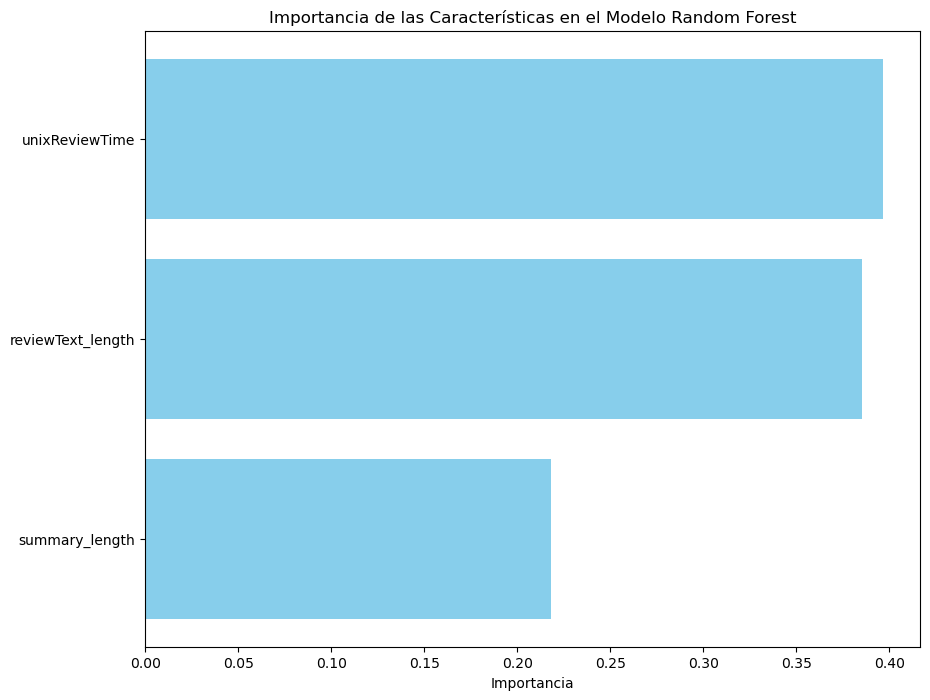


Precisión del modelo con características seleccionadas: 0.60
Precisión de Random Forest: 0.60
Precisión de Gradient Boosting: 0.63
Precisión de Decision Tree: 0.45
Precisión de Logistic Regression: 0.64


In [5]:
# Importamos las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score

# Ajustamos la columna 'helpful' para obtener el número de votos útiles
valoraciones['helpful_votes'] = valoraciones['helpful'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 0)

# Convertimos todas las columnas de tipo object a valores numéricos
for column in valoraciones.select_dtypes(include=['object']).columns:
    if column == 'reviewText':
        # Nueva característica con la longitud del texto
        valoraciones['reviewText_length'] = valoraciones['reviewText'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    elif column == 'summary':
        # Nueva característica con la longitud del resumen
        valoraciones['summary_length'] = valoraciones['summary'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    else:
        # Eliminamos columnas irrelevantes
        valoraciones = valoraciones.drop(columns=[column])

# Seleccionamos todas las características menos la columna objetivo 'overall'
X = valoraciones[['unixReviewTime', 'reviewText_length', 'summary_length']]
y = valoraciones['overall']

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Entrenamos un modelo de Random Forest para calcular la importancia de las características
modelo_rf = RandomForestClassifier(random_state=1)
modelo_rf.fit(X_train, y_train)

# Obtenemos la importancia de las características
importancias = modelo_rf.feature_importances_
features = X.columns

# Creamos un DataFrame para visualizar la importancia de cada característica
importantesDf = pd.DataFrame({'Feature': features, 'Importance': importancias})
importantesDf = importantesDf.sort_values(by='Importance', ascending=False)

# Mostrar DataFrame de importancias
print("\nImportancia de las características:")
print(importantesDf)

# Visualizamos las importancias de características
plt.figure(figsize=(10, 8))
plt.barh(importantesDf['Feature'], importantesDf['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las Características en el Modelo Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Filtramos las características menos relevantes según un umbral de importancia
umbral_importancia = 0.01  # Ajusta este valor según los resultados
mejores_features = importantesDf[importantesDf['Importance'] > umbral_importancia]['Feature'].tolist()

# Creamos el conjunto de datos final solo con las características más relevantes
X_train_mejores = X_train[mejores_features]
X_test_mejores = X_test[mejores_features]

# Entrenamos y evaluamos el modelo con las características seleccionadas
modelo_final = RandomForestClassifier(random_state=1)
modelo_final.fit(X_train_mejores, y_train)
predicciones_final = modelo_final.predict(X_test_mejores)
accuracy_final = modelo_final.score(X_test_mejores, y_test)
print(f'\nPrecisión del modelo con características seleccionadas: {accuracy_final:.2f}')

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Definimos los modelos a comparar
modelos = {
    'Random Forest': RandomForestClassifier(random_state=1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=1),
    'Decision Tree': DecisionTreeClassifier(random_state=1),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=1)
}

# Evaluamos cada modelo
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X_test)
    accuracy = accuracy_score(y_test, predicciones)
    print(f'Precisión de {nombre}: {accuracy:.2f}')

## Buscar missing values

In [6]:
# Defino una función que me ayude a comparar las diferentes estrategias.
def score_dataset(X_train, X_valid, y_train, y_valid):
    ''' 
    Función para comparar estrategias y devolver el MAE 
    '''
    model = RandomForestRegressor(n_estimators=73, random_state=1)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# Contamos los valores faltantes en cada columna
missing_values = valoraciones.isnull().sum()

# Filtramos solo las columnas que tienen valores faltantes
missing_values = missing_values[missing_values > 0]

# Mostramos los resultados
print("Valores faltantes por columna:")
print(missing_values)

# Identificar columnas con valores faltantes
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]



Valores faltantes por columna:
Series([], dtype: int64)


## Técnicas de Tratamiento de Valores Faltantes y Preparación de Datos

En este documento se detallan las técnicas utilizadas para tratar valores faltantes y preparar los datos para el modelado. Cada técnica tiene sus propias ventajas y limitaciones, y la selección de cada una depende del contexto y las características de los datos.

## 1. Imputación Básica con la Media
La **imputación básica con la media** consiste en reemplazar los valores faltantes de cada columna por la media de esa columna. Este método es útil cuando los valores están distribuidos simétricamente, ya que la media representa el "centro" de la distribución de datos.

**Ventajas**:

- Sencillo de implementar.
- Mantiene el tamaño del conjunto de datos.

**Desventajas**:

- Puede sesgar los resultados si hay valores extremos.
- No conserva la variabilidad en los datos.


In [7]:
# Imputación básica con la media
from sklearn.impute import SimpleImputer

# Imputación básica (media) como referencia
imputer = SimpleImputer(strategy='mean')
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(imputer.transform(X_test))
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_test.columns

print("MAE (imputación con media):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_test))

MAE (imputación con media):
0.9354842117671656


## 2. Imputación con Extensión Utilizando la Media
La **imputación con extensión** consiste en crear indicadores adicionales que registran si un valor era originalmente faltante. Luego, se imputa el valor faltante usando la media, lo que ayuda a conservar la información sobre los datos faltantes y permite al modelo "saber" que se ha realizado una imputación.

**Ventajas**:

- Conserva información sobre la ausencia de datos.
- Puede mejorar el rendimiento del modelo si los datos faltantes siguen un patrón.

**Desventajas**:

- Aumenta el número de características en el conjunto de datos.
- Puede agregar complejidad innecesaria si los valores faltantes son aleatorios.

In [8]:
# Imputación con extensión utilizando la media
X_train_plus = X_train.copy()
X_valid_plus = X_test.copy()

# Añadir indicadores de valores faltantes
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputar la media
imputer = SimpleImputer(strategy='mean')
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train_plus))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid_plus))
imputed_X_train.columns = X_train_plus.columns
imputed_X_valid.columns = X_valid_plus.columns

print("MAE (imputación con extensión y media):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_test))

MAE (imputación con extensión y media):
0.9354842117671656


## 3. Imputación con Extensión Utilizando la Mediana
La **imputación con extensión utilizando la mediana** es similar al método anterior, pero reemplaza los valores faltantes por la mediana de cada columna en lugar de la media. Es útil cuando los datos tienen una distribución sesgada o contienen valores atípicos, ya que la mediana es menos sensible a los valores extremos.

**Ventajas**:

- Reduce el sesgo causado por valores atípicos.
- Mantiene la robustez en presencia de distribuciones sesgadas.

**Desventajas**:

- Puede no capturar bien la media si los datos están distribuidos simétricamente.
- Al igual que la media, puede reducir la variabilidad original de los datos.

In [9]:
# Imputación con extensión utilizando la mediana
X_train_plus = X_train.copy()
X_valid_plus = X_test.copy()

for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

imputer = SimpleImputer(strategy='median')
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train_plus))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid_plus))
imputed_X_train.columns = X_train_plus.columns
imputed_X_valid.columns = X_valid_plus.columns

print("MAE (imputación con extensión y mediana):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_test))

MAE (imputación con extensión y mediana):
0.9354842117671656


## 4. Imputación con Extensión Utilizando la Moda
La **imputación con extensión utilizando la moda** reemplaza los valores faltantes por el valor más frecuente (o moda) de cada columna. Este método es especialmente útil para datos categóricos, donde la moda representa el valor que ocurre con mayor frecuencia.

**Ventajas**:

- Muy útil para datos categóricos.
- Mantiene la distribución de valores en columnas con poca variabilidad.

**Desventajas**:

- Puede introducir sesgo si la moda no representa bien los valores faltantes.
- Menos adecuado para datos numéricos continuos.

In [10]:
# Imputación con extensión utilizando la moda
X_train_plus = X_train.copy()
X_valid_plus = X_test.copy()

for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

imputer = SimpleImputer(strategy='most_frequent')
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train_plus))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid_plus))
imputed_X_train.columns = X_train_plus.columns
imputed_X_valid.columns = X_valid_plus.columns

print("MAE (imputación con extensión y moda):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_test))

MAE (imputación con extensión y moda):
0.9354842117671656


## 5. Imputación con Extensión Utilizando un Valor Constante
La **imputación con un valor constante** es una técnica donde se reemplazan los valores faltantes con un valor específico (por ejemplo, `0` o `-1`). Este método es útil cuando se desea marcar valores faltantes con un indicador específico o cuando el contexto permite asignar un valor neutro o común.

**Ventajas**:

- Proporciona flexibilidad para seleccionar el valor de imputación.
- Útil para valores categóricos o cuando el valor faltante tiene un significado específico.

**Desventajas**:

- Puede no ser adecuado si el valor constante no tiene sentido en el contexto de los datos.
- Puede afectar negativamente el rendimiento del modelo si el valor elegido introduce ruido.


In [11]:
# Imputación con extensión utilizando un valor constante
X_train_plus = X_train.copy()
X_valid_plus = X_test.copy()

for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

imputer = SimpleImputer(strategy='constant', fill_value=0)
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train_plus))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid_plus))
imputed_X_train.columns = X_train_plus.columns
imputed_X_valid.columns = X_valid_plus.columns

print("MAE (imputación con extensión y valor constante):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_test))

MAE (imputación con extensión y valor constante):
0.9354842117671656


## 6. Eliminación de Columnas con Valores Faltantes
La **eliminación de columnas con valores faltantes** consiste en eliminar cualquier columna que contenga valores faltantes. Es una técnica útil si hay pocas columnas con valores faltantes o si las columnas no son esenciales para el modelo.

**Ventajas**:

- Sencilla de implementar y asegura que no haya datos faltantes en el conjunto final.
- Puede mejorar la eficiencia al reducir el número de características.

**Desventajas**:

- Puede resultar en la pérdida de información importante si las columnas eliminadas son relevantes.
- No es adecuado si muchas columnas contienen valores faltantes.

In [12]:
# Selecciono las columnas con valores faltantes en el conjunto de entrenamiento.
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]

# Elimino las columnas de los datos de entrenamiento y validación.
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_test.drop(cols_with_missing, axis=1)

# Calculo el MAE usando el conjunto de datos con columnas eliminadas.
print("MAE (eliminar columnas):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_test))


MAE (eliminar columnas):
0.9354842117671656


# Resumen Preproceso de datos 

In [13]:
# Inputacion utilizando la media
print("MAE (imputación con media):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_test))

# Inputacion con extensión utilizando la media
print("MAE (imputación con extensión y media):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_test))

# Inputacion con extensión utilizando la mediana 
print("MAE (imputación con extensión y mediana):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_test))

# Imputacion con extension utilizando la moda 
print("MAE (imputación con extensión y moda):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_test))

# Calculo el MAE usando un valor constante
print("MAE (imputación con extensión y valor constante):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_test))

# Calculo el MAE usando el conjunto de datos con columnas eliminadas.
print("MAE (eliminar columnas):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_test))

MAE (imputación con media):
0.9354842117671656
MAE (imputación con extensión y media):
0.9354842117671656
MAE (imputación con extensión y mediana):
0.9354842117671656
MAE (imputación con extensión y moda):
0.9354842117671656
MAE (imputación con extensión y valor constante):
0.9354842117671656
MAE (eliminar columnas):
0.9354842117671656



# Técnicas de Transformación de Variables Categóricas

Al preparar datos para un modelo de machine learning, es importante transformar las variables categóricas en un formato numérico adecuado. A continuación, se describen tres técnicas comunes para trabajar con variables categóricas.

## Eliminación de Variables Categóricas

La **eliminación de variables categóricas** consiste en descartar aquellas columnas categóricas que no son necesarias o que pueden introducir ruido en el modelo. Esta técnica es útil cuando ciertas variables categóricas no aportan información significativa o cuando el conjunto de datos tiene demasiadas categorías, lo que complica el proceso de codificación.

**Ventajas**:

- Sencillo de implementar, ya que solo requiere eliminar columnas.
- Reduce la dimensionalidad del conjunto de datos, mejorando la eficiencia.

**Desventajas**:

- Puede perderse información valiosa si las variables eliminadas son relevantes.
- No adecuado si se pierden variables importantes para el modelo.

In [14]:
#Eliminación variables categoricas 
# Seleccionamos solo las columnas numéricas y eliminamos variables categóricas
X_numerico = valoraciones.select_dtypes(exclude=['object'])
X_train, X_test, y_train, y_test = train_test_split(X_numerico, y, test_size=0.2, random_state=1)

# Entrenamos un modelo de Random Forest usando solo variables numéricas
modelo_rf = RandomForestClassifier(random_state=1)
modelo_rf.fit(X_train, y_train)

# Evaluamos el modelo
accuracy = modelo_rf.score(X_test, y_test)
print(f'Precisión del modelo tras eliminar variables categóricas: {accuracy:.2f}')


Precisión del modelo tras eliminar variables categóricas: 1.00


## Codificación Ordinal (Ordinal Encoding)

La **codificación ordinal** asigna un valor numérico a cada categoría en una columna, siguiendo un orden. Este método es adecuado para variables categóricas que tienen un orden inherente, como "Bajo", "Medio" y "Alto". Con este enfoque, se asignan valores enteros a cada nivel de la categoría en orden creciente o decreciente.
**Ventajas**:

- Mantiene el orden natural de las categorías, lo que es importante para variables ordinales.
- Sencillo de implementar y no aumenta la dimensionalidad del conjunto de datos.

**Desventajas**:

- No es adecuado para variables categóricas sin un orden específico, ya que introduce relaciones numéricas que no existen.
- Puede causar problemas si el modelo interpreta los valores numéricos como cantidades en lugar de categorías.


In [15]:
from sklearn.preprocessing import OrdinalEncoder

# Seleccionamos las columnas categóricas
categoricas = valoraciones.select_dtypes(include=['object']).copy()

# Codificamos las columnas categóricas ordinales
ordinal_encoder = OrdinalEncoder()
categoricas_encoded = pd.DataFrame(ordinal_encoder.fit_transform(categoricas), columns=categoricas.columns)

# Combinamos las columnas numéricas y las codificadas ordinalmente
X_ordinal = pd.concat([X_numerico.reset_index(drop=True), categoricas_encoded], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_ordinal, y, test_size=0.2, random_state=1)

# Entrenamos el modelo
modelo_rf.fit(X_train, y_train)
accuracy = modelo_rf.score(X_test, y_test)
print(f'Precisión del modelo con codificación ordinal: {accuracy:.2f}')


Precisión del modelo con codificación ordinal: 1.00


### Codificación One-Hot (One-Hot Encoding)

La **codificación one-hot** convierte cada categoría en una columna binaria, donde se indica la presencia o ausencia de cada categoría con valores de `1` o `0`. Este método es adecuado para variables categóricas sin orden, como "Rojo", "Verde" y "Azul", ya que evita introducir relaciones numéricas entre categorías.

**Ventajas**:

- Evita introducir relaciones numéricas no deseadas en las variables categóricas sin orden.
- Facilita la interpretación del modelo cuando cada categoría tiene su propia columna.

**Desventajas**:

- Aumenta la dimensionalidad del conjunto de datos, especialmente cuando hay muchas categorías, lo que puede ralentizar el proceso de entrenamiento.
- Puede requerir mucho almacenamiento y procesamiento, especialmente para variables con un gran número de categorías.


In [16]:
from sklearn.preprocessing import OneHotEncoder

# Inicializamos el codificador One-Hot y aplicamos la codificación
one_hot_encoder = OneHotEncoder(sparse_output=False)
categoricas_one_hot = one_hot_encoder.fit_transform(categoricas)

# Convertimos el resultado en un DataFrame con nombres de columnas
categoricas_one_hot_df = pd.DataFrame(categoricas_one_hot, columns=one_hot_encoder.get_feature_names_out(categoricas.columns))

# Combinamos las columnas numéricas y las codificadas con One-Hot
X_one_hot = pd.concat([X_numerico.reset_index(drop=True), categoricas_one_hot_df.reset_index(drop=True)], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_one_hot, y, test_size=0.2, random_state=1)

# Entrenamos el modelo
modelo_rf = RandomForestClassifier(random_state=1)
modelo_rf.fit(X_train, y_train)
accuracy = modelo_rf.score(X_test, y_test)
print(f'Precisión del modelo con codificación One-Hot: {accuracy:.2f}')


Precisión del modelo con codificación One-Hot: 0.97


## Outliers
- métodos IQR

Cantidad de outliers detectados: 955


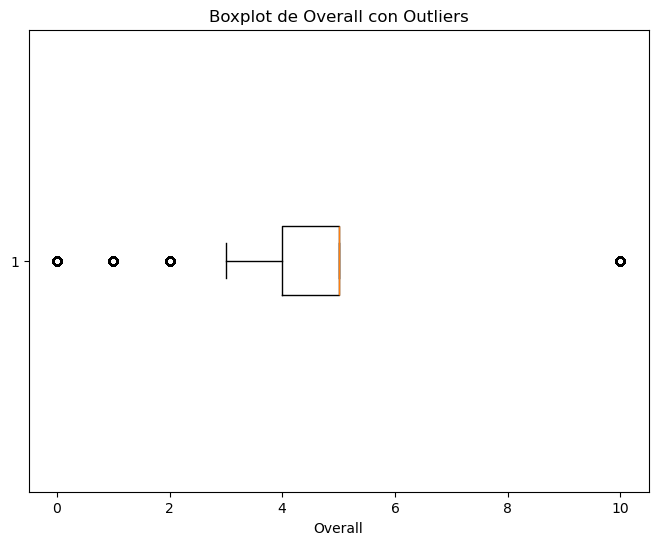

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Calculamos los cuartiles y el rango intercuartílico (IQR)
Q1 = valoraciones['overall'].quantile(0.25)
Q3 = valoraciones['overall'].quantile(0.75)
IQR = Q3 - Q1

# Definimos los límites inferior y superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificamos outliers
outliers = valoraciones[(valoraciones['overall'] < lower_bound) | (valoraciones['overall'] > upper_bound)]
print(f"Cantidad de outliers detectados: {len(outliers)}")

# Visualizamos los outliers con un boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(valoraciones['overall'], vert=False)
plt.title('Boxplot de Overall con Outliers')
plt.xlabel('Overall')
plt.show()


z-score.

Cantidad de outliers detectados con Z-score: 513


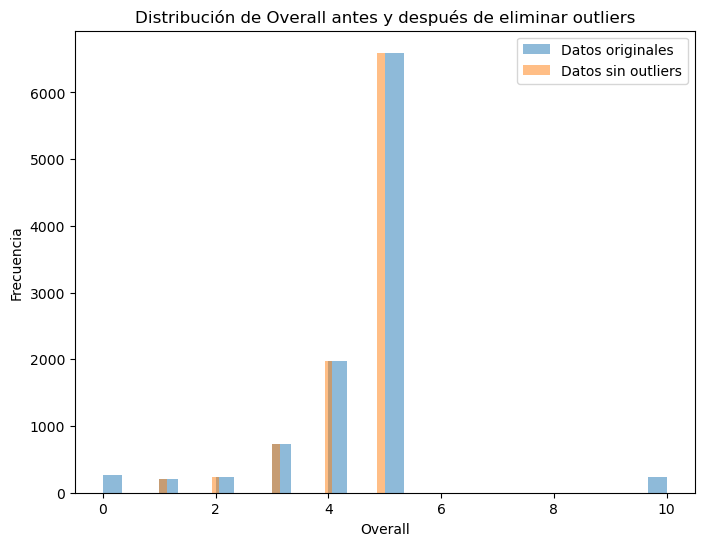

In [18]:
from scipy.stats import zscore
import numpy as np

# Calculamos el Z-score para la columna 'overall'
z_scores = zscore(valoraciones['overall'])

# Definimos un umbral para considerar un valor como outlier (usualmente 3 o -3)
threshold = 3

# Identificamos outliers basándonos en el Z-score
outliers_z = valoraciones[np.abs(z_scores) > threshold]
print(f"Cantidad de outliers detectados con Z-score: {len(outliers_z)}")

# Visualizamos los datos con y sin outliers
plt.figure(figsize=(8, 6))
plt.hist(valoraciones['overall'], bins=30, alpha=0.5, label='Datos originales')
plt.hist(valoraciones[np.abs(z_scores) <= threshold]['overall'], bins=30, alpha=0.5, label='Datos sin outliers')
plt.title('Distribución de Overall antes y después de eliminar outliers')
plt.xlabel('Overall')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


## Discretización 

In [19]:
# Definimos los intervalos y etiquetas
bins = [0, 2, 3, 5]  # 0-2, 3, 4-5
labels = ['Negativo', 'Neutro', 'Positivo']

# Discretizamos la variable 'overall'
valoraciones['overall_categoria'] = pd.cut(valoraciones['overall'], bins=bins, labels=labels)

# Verificamos la distribución de las categorías
print(valoraciones['overall_categoria'].value_counts())


overall_categoria
Positivo    8576
Neutro       730
Negativo     442
Name: count, dtype: int64


## Impacto en el modelo

In [20]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# Paso 2: Discretizar la variable 'overall' en categorías
bins = [0, 2, 3, 5]  # 1-2: Negativo, 3: Neutro, 4-5: Positivo
labels = ['Negativo', 'Neutro', 'Positivo']
valoraciones['overall_categoria'] = pd.cut(valoraciones['overall'], bins=bins, labels=labels)

# Paso 3: Codificar la variable objetivo 'overall_categoria'
label_encoder = LabelEncoder()
valoraciones['overall_categoria_encoded'] = label_encoder.fit_transform(valoraciones['overall_categoria'])

# Paso 4: Preparar las variables predictoras (X) y la variable objetivo (y)
X = valoraciones.drop(columns=['overall', 'overall_categoria', 'overall_categoria_encoded', 'reviewText'])
y = valoraciones['overall_categoria_encoded']

# Verificar y convertir las columnas categóricas a cadenas si es necesario
categoricas = X.select_dtypes(include=['object']).columns
for col in categoricas:
    X[col] = X[col].astype(str)  # Convertimos todas las columnas categóricas a tipo string

# Codificar variables categóricas en X
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categoricas_encoded = one_hot_encoder.fit_transform(X[categoricas])
categoricas_encoded_df = pd.DataFrame(categoricas_encoded, columns=one_hot_encoder.get_feature_names_out(categoricas))

# Combinar con las columnas numéricas
X_numerico = X.select_dtypes(exclude=['object']).reset_index(drop=True)
X_procesado = pd.concat([X_numerico, categoricas_encoded_df], axis=1)

# Paso 5: Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_procesado, y, test_size=0.2, random_state=1)

# Paso 6: Entrenar el modelo RandomForestClassifier
modelo_rf = RandomForestClassifier(random_state=1)
modelo_rf.fit(X_train, y_train)

# Paso 7: Evaluar el modelo
y_pred = modelo_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo tras corrección: {accuracy:.2f}")

# Paso 8: Generar el informe de clasificación
target_names = [str(cls) for cls in label_encoder.classes_]  # Aseguramos que todas las clases sean cadenas
print("\nInforme de clasificación:\n", classification_report(y_test, y_pred, target_names=target_names))


Precisión del modelo tras corrección: 0.84

Informe de clasificación:
               precision    recall  f1-score   support

    Negativo       0.80      0.05      0.09        86
      Neutro       0.83      0.03      0.06       154
    Positivo       0.84      1.00      0.91      1719
         nan       0.00      0.00      0.00        94

    accuracy                           0.84      2053
   macro avg       0.62      0.27      0.27      2053
weighted avg       0.80      0.84      0.77      2053



## Reducción de Dimensionalidad:

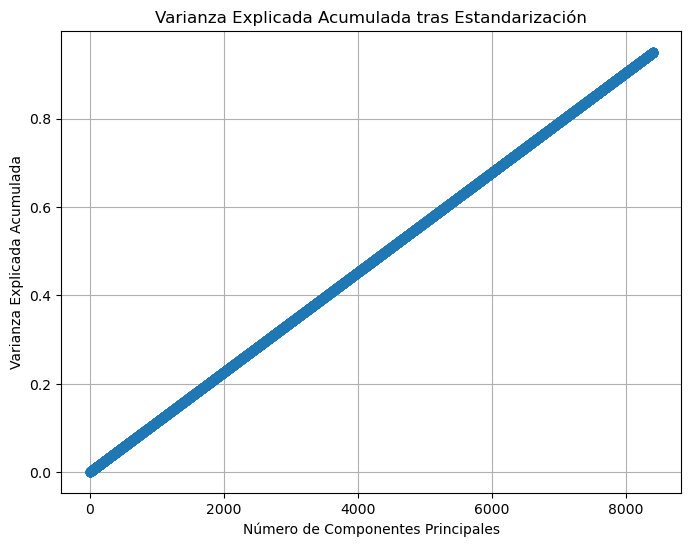

Número de componentes seleccionados para explicar el 95% de la varianza: 8409
Precisión del modelo tras PCA y estandarización: 0.84


In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Discretizar la variable 'overall'
bins = [0, 2, 3, 5]
labels = ['Negativo', 'Neutro', 'Positivo']
valoraciones['overall_categoria'] = pd.cut(valoraciones['overall'], bins=bins, labels=labels)

# Codificar la variable objetivo
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
valoraciones['overall_categoria_encoded'] = label_encoder.fit_transform(valoraciones['overall_categoria'])

# Preparar variables predictoras (X) y objetivo (y)
X = valoraciones.drop(columns=['overall', 'overall_categoria', 'overall_categoria_encoded', 'reviewText'])
y = valoraciones['overall_categoria_encoded']

# Codificar variables categóricas
categoricas = X.select_dtypes(include=['object']).columns
for col in categoricas:
    X[col] = X[col].astype(str)

one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categoricas_encoded = one_hot_encoder.fit_transform(X[categoricas])
categoricas_encoded_df = pd.DataFrame(categoricas_encoded, columns=one_hot_encoder.get_feature_names_out(categoricas))

X_numerico = X.select_dtypes(exclude=['object']).reset_index(drop=True)
X_procesado = pd.concat([X_numerico, categoricas_encoded_df], axis=1)

# Paso 1: Estandarización de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_procesado)

# Paso 2: Aplicar PCA directamente con 95% de varianza explicada
pca = PCA(n_components=0.95)
X_pca_reducido = pca.fit_transform(X_scaled)

# Paso 3: Visualizar la varianza explicada acumulada
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada tras Estandarización')
plt.grid(True)
plt.show()  # Mostrar la gráfica y esperar que el usuario la cierre manualmente

# Número de componentes seleccionados
n_components = X_pca_reducido.shape[1]
print(f"Número de componentes seleccionados para explicar el 95% de la varianza: {n_components}")

# Paso 4: Dividir los datos y entrenar el modelo
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_reducido, y, test_size=0.2, random_state=1)

modelo_rf_pca = RandomForestClassifier(n_estimators=50, random_state=1)  # Reducir n_estimators para optimizar tiempo
modelo_rf_pca.fit(X_train_pca, y_train)

# Paso 5: Evaluar el modelo
y_pred_pca = modelo_rf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Precisión del modelo tras PCA y estandarización: {accuracy_pca:.2f}")


## Estandarización y Normalización

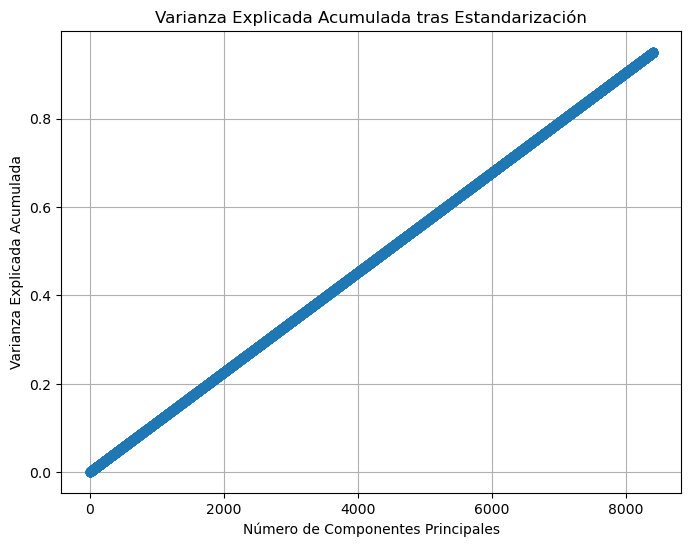

Precisión del modelo con estandarización: 0.84


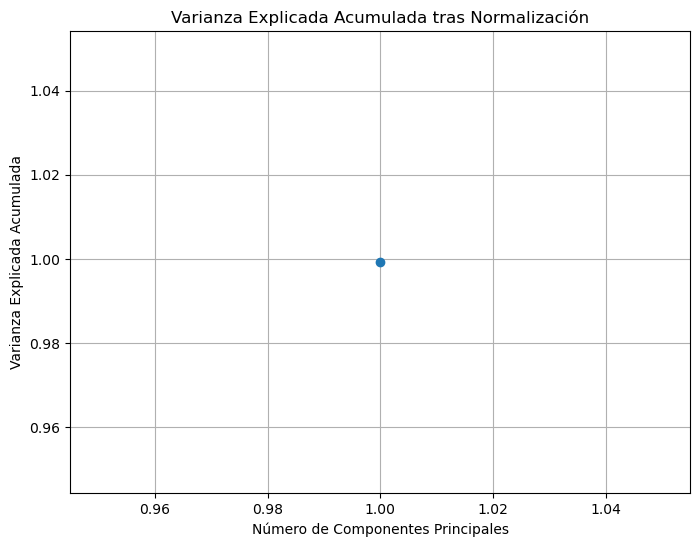

Precisión del modelo con normalización: 0.84


In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Discretización de la variable 'overall'
bins = [0, 2, 3, 5]
labels = ['Negativo', 'Neutro', 'Positivo']
valoraciones['overall_categoria'] = pd.cut(valoraciones['overall'], bins=bins, labels=labels, include_lowest=True)

# Codificación de la variable objetivo
label_encoder = LabelEncoder()
valoraciones['overall_categoria_encoded'] = label_encoder.fit_transform(valoraciones['overall_categoria'])

# Preparar variables predictoras (X) y objetivo (y)
X = valoraciones.drop(columns=[col for col in ['overall', 'overall_categoria', 'overall_categoria_encoded', 'reviewText'] if col in valoraciones])
y = valoraciones['overall_categoria_encoded']

# Codificación de variables categóricas
categoricas = X.select_dtypes(include=['object']).columns
X[categoricas] = X[categoricas].fillna('missing')

one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categoricas_encoded = one_hot_encoder.fit_transform(X[categoricas])
categoricas_encoded_df = pd.DataFrame(categoricas_encoded, columns=one_hot_encoder.get_feature_names_out(categoricas))

X_numerico = X.select_dtypes(exclude=['object']).reset_index(drop=True)
X_procesado = pd.concat([X_numerico, categoricas_encoded_df], axis=1)

### --- OPCIÓN 1: ESTANDARIZACIÓN ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_procesado)

# Aplicar PCA con varianza explicada acumulada del 95% tras estandarización
pca = PCA(n_components=0.95)
X_pca_estandarizado = pca.fit_transform(X_scaled)

# Gráfica de varianza explicada acumulada (Estandarización)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada tras Estandarización')
plt.grid(True)
plt.show()

# Dividir datos y entrenar Random Forest con datos estandarizados
X_train_std, X_test_std, y_train, y_test = train_test_split(X_pca_estandarizado, y, test_size=0.2, random_state=1)

modelo_rf_std = RandomForestClassifier(n_estimators=50, random_state=1)
modelo_rf_std.fit(X_train_std, y_train)

# Evaluar el modelo con estandarización
y_pred_std = modelo_rf_std.predict(X_test_std)
accuracy_std = accuracy_score(y_test, y_pred_std)
print(f"Precisión del modelo con estandarización: {accuracy_std:.2f}")

### --- OPCIÓN 2: NORMALIZACIÓN ---
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X_procesado)

# Aplicar PCA con varianza explicada acumulada del 95% tras normalización
pca_norm = PCA(n_components=0.95)
X_pca_normalizado = pca_norm.fit_transform(X_normalized)

# Gráfica de varianza explicada acumulada (Normalización)
cumulative_variance_ratio_norm = np.cumsum(pca_norm.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio_norm) + 1), cumulative_variance_ratio_norm, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada tras Normalización')
plt.grid(True)
plt.show()

# Dividir datos y entrenar Random Forest con datos normalizados
X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_pca_normalizado, y, test_size=0.2, random_state=1)

modelo_rf_norm = RandomForestClassifier(n_estimators=50, random_state=1)
modelo_rf_norm.fit(X_train_norm, y_train)

# Evaluar el modelo con normalización
y_pred_norm = modelo_rf_norm.predict(X_test_norm)
accuracy_norm = accuracy_score(y_test, y_pred_norm)
print(f"Precisión del modelo con normalización: {accuracy_norm:.2f}")


Paso 2: Análisis de Sentimientos con Técnicas de NLP
Procesamiento de Texto:
Tokenización: Divide reviewText en palabras.
Eliminación de palabras irrelevantes (stopwords).
Lematización o stemming para normalizar palabras.
Extracción de polaridad usando NLTK o similares para identificar el sentimiento.
Justifica cada técnica y evalúa su impacto en el modelo de sentimientos.

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# Asegurar la ruta correcta y descargar recursos
nltk.data.path.append('/Users/markeltrinidad/nltk_data')
nltk.download('punkt', download_dir='/Users/markeltrinidad/nltk_data')
nltk.download('stopwords', download_dir='/Users/markeltrinidad/nltk_data')
nltk.download('wordnet', download_dir='/Users/markeltrinidad/nltk_data')
nltk.download('vader_lexicon', download_dir='/Users/markeltrinidad/nltk_data')

# Cargar el archivo JSON
valoraciones = pd.read_json("data/web_reviews.json")

# Convertir 'overall' en categorías
def categorize_rating(rating):
    if rating <= 2:
        return "negativa"
    elif rating == 3:
        return "neutral"
    else:
        return "positiva"

valoraciones['sentimiento'] = valoraciones['overall'].apply(categorize_rating)

# Tokenización y eliminación de stopwords
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

valoraciones['tokens'] = valoraciones['reviewText'].apply(preprocess_text)

# Lematización
lemmatizer = WordNetLemmatizer()
valoraciones['lemmatized'] = valoraciones['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

# Análisis de polaridad
sia = SentimentIntensityAnalyzer()
valoraciones['polaridad'] = valoraciones['reviewText'].apply(lambda text: sia.polarity_scores(text)['compound'])

# TF-IDF y entrenamiento
tfidf = TfidfVectorizer(max_features=100)
X_text = tfidf.fit_transform(valoraciones['lemmatized'].apply(lambda x: ' '.join(x))).toarray()
y = valoraciones['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=0)
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {accuracy}")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/markeltrinidad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/markeltrinidad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/markeltrinidad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/markeltrinidad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/markeltrinidad/nltk_data'
    - '/opt/anaconda3/envs/SAA/nltk_data'
    - '/opt/anaconda3/envs/SAA/share/nltk_data'
    - '/opt/anaconda3/envs/SAA/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/Users/markeltrinidad/nltk_data'
    - '/Users/markeltrinidad/nltk_data'
    - '/Users/markeltrinidad/nltk_data'
    - '/Users/markeltrinidad/nltk_data'
**********************************************************************
